In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [2]:
import os
import json
from collections import OrderedDict

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import h5py
import dill
from tqdm import tqdm
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from scipy.interpolate import interp1d


In [3]:
from agnfinder.prospector import main, load_photometry
from agnfinder import photometry_to_table
from agnfinder.tf_sampling import deep_emulator

In [4]:
os.chdir('/home/walml/repos/agnfinder')

In [5]:
DATA_ROOT = '/home/walml/repos/agnfinder/data'

We'll construct a catalog with magnitudes (and errors) like the catalog loaded here

In [12]:
parquet_loc = os.path.join(DATA_ROOT, 'photometry_quicksave.parquet')  # should be df with loaded photometry in maggies

In [13]:
df = pd.read_parquet(parquet_loc)

In [14]:
bands = df.columns.values[:12]
errors = df.columns.values[12:]
# 11 bands, hardcoded for now
bands, errors

(array(['u_sloan', 'g_sloan', 'r_sloan', 'i_sloan', 'z_sloan', 'VISTA_H',
        'VISTA_J', 'VISTA_Ks', 'VISTA_Y', 'VISTA_Z', 'wise_w1', 'wise_w2'],
       dtype=object),
 array(['u_sloan_err', 'g_sloan_err', 'r_sloan_err', 'i_sloan_err',
        'z_sloan_err', 'VISTA_H_err', 'VISTA_J_err', 'VISTA_Ks_err',
        'VISTA_Y_err', 'VISTA_Z_err', 'wise_w1_err', 'wise_w2_err'],
       dtype=object))

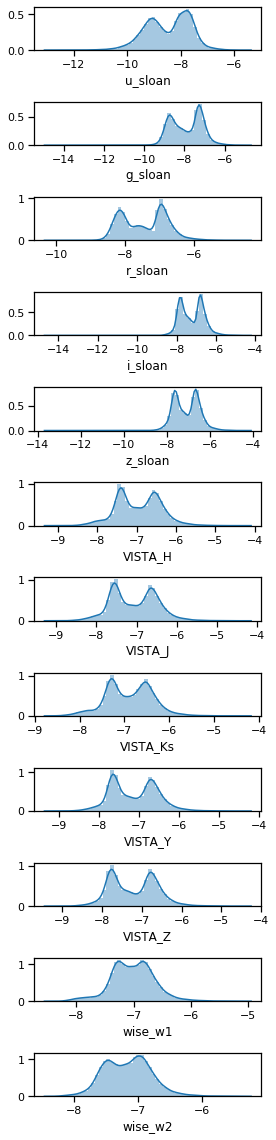

In [15]:
# bimodal because of the high-z QSO, presumably
fig, axes = plt.subplots(nrows=len(bands), figsize=(4, 16))
for n, band in enumerate(bands):
    ax = axes[n]
    sns.distplot(np.log10(df[band]), ax=ax)
fig.tight_layout()

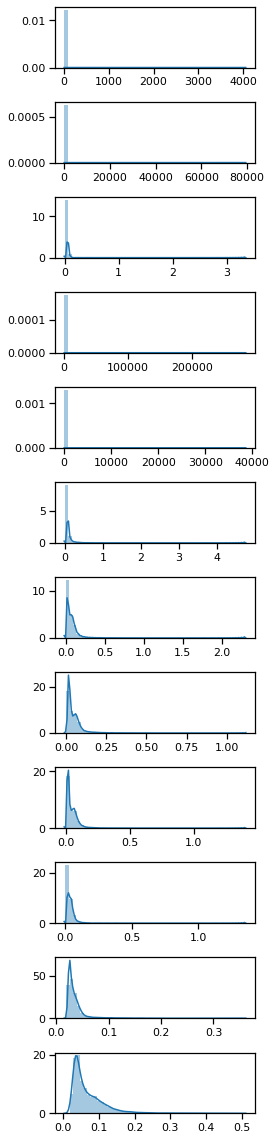

In [106]:
# bimodal because of the high-z QSO, presumably
fig, axes = plt.subplots(nrows=len(bands), figsize=(4, 16))
for n, band in enumerate(bands):
    ax = axes[n]
    sns.distplot(df[errors[n]]/df[band], ax=ax)
fig.tight_layout()

Let's do the same but now recording the distributions, rather than automatically with seaborn

In [14]:
from scipy.stats import gaussian_kde

In [17]:
kdes = {}
for band in bands:
    kdes[band] = gaussian_kde(np.log10(df[band]))

In [96]:
with open(os.path.join(DATA_ROOT, 'cpz_maggie_kdes.pickle'), 'wb') as f:
    dill.dump(kdes, f)

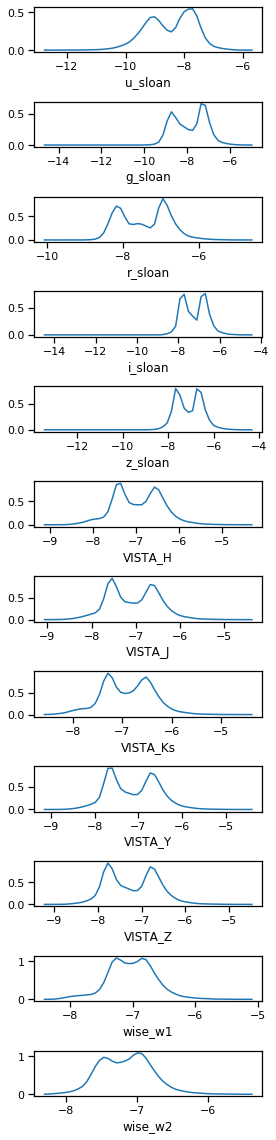

In [19]:
fig, axes = plt.subplots(nrows=len(bands), figsize=(4, 16))
for n, band in enumerate(bands):
    ax = axes[n]
    x = np.linspace(np.log10(df[band].min()), np.log10(df[band].max()))
    ax.plot(x, kdes[band](x))
    ax.set_xlabel(band)
fig.tight_layout()

Great. Let's test that we can sample a non-random grid using pairwise matching

- draw a set of maggies from the kdes above (all bands)
- find the galaxy in the cube with the most similar maggies (code already exists)
- select that galaxy (and do not select again)

These cube galaxies will have different underlying parameters (we can't know these for real galaxies) but will be observationally identical

But hmm - the bands are highly dependent on each other (see notes).
Sampling from marginals != sampling from joint!

Instead, let's be simple:
- pick a real galaxy
- find the synthetic pair, do not pick again

In [30]:
cube_dir = 'data/cubes/latest'

In [31]:
_, _, x_test, y_test = deep_emulator.data(cube_dir)

In [25]:
x_test.shape, y_test.shape

((30000, 9), (30000, 8))

In [45]:
bands

array(['u_sloan', 'g_sloan', 'r_sloan', 'i_sloan', 'z_sloan', 'VISTA_H',
       'VISTA_J', 'VISTA_Ks', 'VISTA_Y', 'VISTA_Z', 'wise_w1', 'wise_w2'],
      dtype=object)

In [7]:
euclid_bands = ['u_sloan', 'g_sloan', 'r_sloan', 'i_sloan', 'z_sloan', 'VISTA_H',
       'VISTA_J', 'VISTA_Y']

In [47]:
output_dim = 8
n_galaxies = 1000


Convert the whole thing to a function

In [102]:
def find_closest_galaxies(input_rows: np.array, candidates: np.array, duplicates: bool):
    pairs = []
    used_indices = set()
    for n, photometry in tqdm(enumerate(input_rows), total=len(input_rows)):
        error = np.sum((photometry - candidates) ** 2, axis=1)
        lowest_k_indices = np.argpartition(error, len(input_rows))  # find the lowest (catalog n) rows, don't bother sorting the rest
        lowest_k = error[lowest_k_indices]
        sorted_lowest_k_indices = np.argsort(lowest_k) # indices to sort the lowest k rows, *indexed only to the lowest k*
        sorted_indices = lowest_k_indices[sorted_lowest_k_indices]
        for index in sorted_indices:
            if index in used_indices:
                pass
            else: # use
                pairs.append(index)
                if duplicates is False:  # don't re-use
                    used_indices.add(index)  
                break
        if index == sorted_indices[-1]:
            raise ValueError('No match found, should be impossible?')
            
    return pairs


def select_subsample(photometry_df: pd.DataFrame, cube_y: np.array, duplicates=False):
    
    bands = ['u_sloan', 'g_sloan', 'r_sloan', 'i_sloan', 'z_sloan', 'VISTA_H',
       'VISTA_J', 'VISTA_Y']  # euclid
    assert cube_y.shape[1] == len(bands)
    
    # trim real photometry outliers
    limits = {}
    for band in bands:
        limits[band] = (np.percentile(photometry_df[band], 2), np.percentile(photometry_df[band], 98))
    df_clipped = photometry_df.copy()
    for band in bands:
        lower_lim = limits[band][0]
        upper_lim = limits[band][1]
        df_clipped = photometry_df.query(f'{band} > {lower_lim}').query(f'{band} < {upper_lim}').reset_index()  # new index ONLY matches this new df, don't apply to old df

    all_photometry = -np.log10([row for _, row in df_clipped[bands].iterrows()])
    
    pairs = find_closest_galaxies(all_photometry, cube_y, duplicates=duplicates)
    return df_clipped, pairs



In [103]:
df_clipped, pairs = select_subsample(df, y_test)

100%|██████████| 30706/30706 [03:58<00:00, 128.90it/s]


In [93]:
len(pairs), len(df_clipped), len(df)

(30706, 30706, 31986)

In [82]:
df_clipped.iloc[pairs[0]]

u_sloan         6.412515e-08
g_sloan         3.040410e-07
r_sloan         5.980975e-07
i_sloan         8.351408e-07
z_sloan         1.068088e-06
VISTA_H         9.431143e-07
VISTA_J         1.345108e-06
VISTA_Ks        1.274958e-06
VISTA_Y         1.253121e-06
VISTA_Z         1.047343e-06
wise_w1         6.119457e-07
wise_w2         3.278720e-07
u_sloan_err     1.099868e-09
g_sloan_err     9.548565e-10
r_sloan_err     1.579889e-09
i_sloan_err     2.305670e-09
z_sloan_err     5.296005e-09
VISTA_H_err     8.703823e-09
VISTA_J_err     8.269902e-09
VISTA_Ks_err    8.523216e-09
VISTA_Y_err     5.845274e-09
VISTA_Z_err     2.995786e-09
wise_w1_err     1.291262e-08
wise_w2_err     7.820800e-09
Name: 9373, dtype: float64

In [74]:
pd.value_counts(pairs)

2047     1
32165    1
5512     1
1418     1
13708    1
        ..
25369    1
31514    1
29467    1
19228    1
0        1
Length: 30706, dtype: int64

In [6]:
# x_test = np.loadtxt('data/cubes/x_test.npy')
# y_test = np.loadtxt('data/cubes/y_test.npy')# need to copy from Zeus...

In [101]:
x_test.shape, y_test.shape

((60000, 9), (60000, 8))

In [98]:
paired_df = pd.DataFrame(data=y_test[pairs], columns=euclid_bands)

In [99]:
paired_df.head()

,u_sloan,g_sloan,r_sloan,i_sloan,z_sloan,VISTA_H,VISTA_J,VISTA_Y
0,7.733960,7.322436,7.144306,6.934414,6.873788,6.875295,6.875680,6.875798
1,7.786344,7.193643,6.940090,6.805425,6.638703,6.576973,6.632968,6.598034
2,8.635865,7.832004,7.352499,7.036907,6.934168,6.598742,6.746812,6.926489
3,7.639923,7.205079,7.020884,6.816730,6.760985,6.740872,6.746799,6.776494
4,8.339796,7.547623,7.172520,6.850236,6.714757,6.543850,6.608001,6.697766


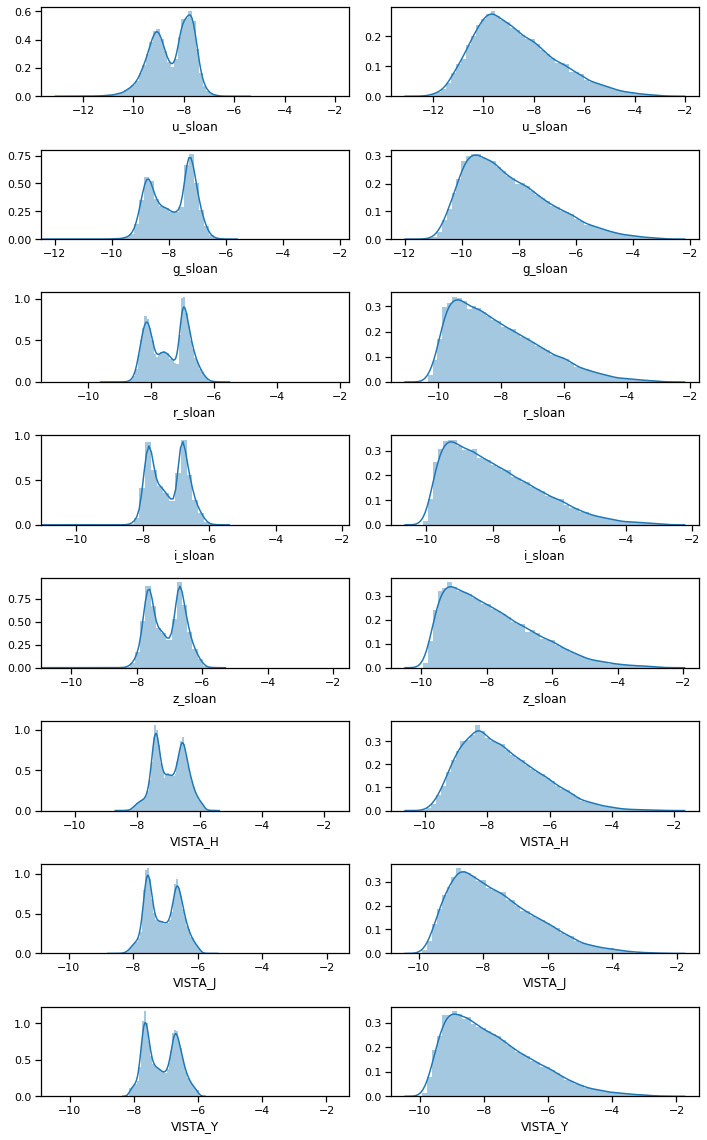

In [100]:
fig, axes = plt.subplots(nrows=len(euclid_bands), ncols=2, figsize=(10, 16))
for n, band in enumerate(euclid_bands):
    row = axes[n]
    sns.distplot(np.log10(df_clipped[band]), ax=row[0])
    sns.distplot(-paired_df[band], ax=row[1])
    # set the same limits
    row[0].set_xlim(row[1].get_xlim())
fig.tight_layout()